#Start

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import re
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

import random
from random import sample
# specify GPU
device = torch.device("cuda")

In [ ]:

import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
open_file = open('/content/tokenized.pkl', "rb")
tokenized_paragraphs = pickle.load(open_file)

open_file2 = open('/content/y.pkl','rb')
y_data = pickle.load(open_file2)


numpy_array = []
counter = 0
y_array = []
for i in range(len(tokenized_paragraphs)):
      len_para = len(tokenized_paragraphs[i])
      if len_para < 255:
        string = " ".join(tokenized_paragraphs[i])
        numpy_array.append(string)
        y_array.append(y_data[i])
      else:
        counter +=1
      
numpy_array = np.asarray(numpy_array)[:5000]
y_array = y_array[:5000]
print(len(numpy_array))

train_text, temp_text, train_labels, temp_labels = train_test_split(numpy_array, y_array, 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=y_array)


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
tokenizer.add_tokens("[START]", special_tokens=True)
tokenizer.add_tokens("[END]", special_tokens=True)

encoded =  tokenizer.encode(numpy_array[0])
encoded2 =  tokenizer.encode(numpy_array[1])
print(numpy_array[1])
print(encoded2)
print(tokenizer.encode("[START] [END] [SEP]"))
print(tokenizer.encode("[SEP]"))
print(tokenizer.encode("[END]"))
print(tokenizer.encode("[START]"))




# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 256,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 256,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 256,
    pad_to_max_length=True,
    truncation=True
)

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels)

Downloading...
From: https://drive.google.com/uc?id=1829Hbb_fKo6h8Qq35E1IpGX9G87uCE9O
To: /content/tokenized.pkl
100% 531M/531M [00:02<00:00, 242MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0oSPv1A0kYl_koDXDD3bLwDg_KzPEYU
To: /content/y.pkl
100% 643k/643k [00:00<00:00, 40.6MB/s]
5000
this procedure is intended to catch all coexisting attractors of the system with the specified parameter range. [SEP] note that several initial conditions are effectively used troughout the process, and a bifurcation diagram is not the behavior of a single trajectory. [SEP] [START] we have made several plots, as a test, with different initial conditions and the diagrams obtained are identical. [END] [SEP] we show several examples of this kind of bifurcation diagram below, where they are being compared with the corresponding behavior of the current. [SEP] having broadly understood the wide range of behavior for individual trajectories in this system, we now turn in the next section to a discu

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
vali = val_text.tolist()
print(sample(vali[:10], 5))

['this is due to the need of exploiting the whole information contained in apparent magnitude limited samples, and overcoming the critical problem of distortions due to the passage from the redshift to the real space. [SEP] this work shows that results on clustering parameters, obtained with different group individuation recipes, are essentially consistent. [SEP] this does not mean that the values of the links do not matter. [SEP] [START] different thermal configurations have been tested and only one resonator is completly optimized, the two others recently implemented still need some adjustments. [END]', 'they considered two different operations. [SEP] [START] the first would take the state of a bipartite quantum system and transform it into a state that is just the product of the reduced density matrixes of the two subsystems. [END] [SEP] they showed that while both of these processes are impossible in general, they can be realized for particular sets of input states. [SEP] an approx

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

bert.resize_token_embeddings(len(tokenizer))


class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.2)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x


path = '/content/saved_weights.pt'
model = BERT_Arch(bert)
model.load_state_dict(torch.load(path, map_location='cpu'))


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading...
From: https://drive.google.com/uc?id=1w9ohms1mDihpCqrdqC1CXnOW1LYRRl82
To: /content/saved_weights.pt
100% 440M/440M [00:01<00:00, 242MB/s]


<All keys matched successfully>

In [ ]:
print(len(test_seq[:5]))

5


In [ ]:
from sklearn.metrics import accuracy_score
import gc
device = 'cpu'
#from GPUtil import showUtilization as gpu_usage

from sklearn import metrics
with torch.no_grad():
  #gpu_usage()
  preds = model(test_seq[:5].to(device), test_mask[:5].to(device))
  preds = preds.detach().cpu().numpy()
  print(preds)
  preds = np.argmax(preds, axis = 1)
  print(preds)
  print(accuracy_score(test_y[:5], preds))

[[-4.0478153  -0.01761471]
 [-0.01168219 -4.4555287 ]
 [-4.4404674  -0.01186045]
 [-4.571619   -0.01039507]
 [-4.1307445  -0.01620151]]
[1 0 1 1 1]
1.0


# Experiments

In [ ]:
print(test_y[:5])
original_array = [tokenizer.decode(x) for x in test_seq[:5]]
for arr in original_array:
  print(arr)


tensor([1, 0, 1, 1, 1])
[CLS] for the cases mentioned above extensions of the interpolative methods should be implemented and its beyond the scope of the present work. [SEP] we can achieve a fast interpolative algorithm for the self [SEP] energy by utilizing a rational representation. [SEP] [START] the coefficients in this interpolation can be found by forcing the self energy to obey several limits and constrains. [END] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [ ]:
# original sentence
s1 = "the paper is arranged as follows. [SEP] [START] we consider the flat friedmann universe with radiation and a positive cosmological constant. [END] [SEP] we are presenting the calculation of the entropy of radiation, event horizon and the total entropy of universe and the respective time evolutions. [SEP] we have also checked the validity of the generalized second law in this section. [SEP] we present the analogous calculations for the flat friedmann universe with non - relativistic matter and a positive cosmological constant. [SEP] we present the particular behaviour of the radiation entropy in the friedmann universe with reference to the development of the event horizon. [SEP] we present the discussion followed by conclusions. [SEP]"

# target sentence one word changed --> try different word types
s2 = "the paper is arranged as follows. [SEP] [START] we consider the flat friedmann universe with radiation and a positive cosmological stupid. [END] [SEP] we are presenting the calculation of the entropy of radiation, event horizon and the total entropy of universe and the respective time evolutions. [SEP] we have also checked the validity of the generalized second law in this section. [SEP] we present the analogous calculations for the flat friedmann universe with non - relativistic matter and a positive cosmological constant. [SEP] we present the particular behaviour of the radiation entropy in the friedmann universe with reference to the development of the event horizon. [SEP] we present the discussion followed by conclusions. [SEP]"

#  target sentence remove first part opviously no proper sentence anymore
s3 = "the paper is arranged as follows. [SEP] [START] universe with radiation and a positive cosmological constant. [END] [SEP] we are presenting the calculation of the entropy of radiation, event horizon and the total entropy of universe and the respective time evolutions. [SEP] we have also checked the validity of the generalized second law in this section. [SEP] we present the analogous calculations for the flat friedmann universe with non - relativistic matter and a positive cosmological constant. [SEP] we present the particular behaviour of the radiation entropy in the friedmann universe with reference to the development of the event horizon. [SEP] we present the discussion followed by conclusions. [SEP]"

# order sentences swapped
s4 = "the paper is arranged as follows. [SEP] we are presenting the calculation of the entropy of radiation, event horizon and the total entropy of universe and the respective time evolutions. [SEP] we have also checked the validity of the generalized second law in this section. [SEP] we present the analogous calculations for the flat friedmann universe with non - relativistic matter and a positive cosmological constant. [SEP] we present the particular behaviour of the radiation entropy in the friedmann universe with reference to the development of the event horizon. [SEP] we present the discussion followed by conclusions. [SEP] [START] we consider the flat friedmann universe with radiation and a positive cosmological constant. [END] [SEP]"

# new target sentence (negative sample)
s5 = "the paper is arranged as follows. [SEP] [START] we consider the flat earth theory a massive blunder in human history and hope that those idiots who came up with this shit stop soon, very soon. [END] [SEP] we are presenting the calculation of the entropy of radiation, event horizon and the total entropy of universe and the respective time evolutions. [SEP] we have also checked the validity of the generalized second law in this section. [SEP] we present the analogous calculations for the flat friedmann universe with non - relativistic matter and a positive cosmological constant. [SEP] we present the particular behaviour of the radiation entropy in the friedmann universe with reference to the development of the event horizon. [SEP] we present the discussion followed by conclusions. [SEP]"

# new surrounding sentence (negative sample)
s6 = "the paper is arranged like a triangle with 4 corners, it is very stupid, so get some chips for the free entertainment. [SEP] [START] we consider the flat friedmann universe with radiation and a positive cosmological constant. [END] [SEP] we are presenting the calculation of the entropy of radiation, event horizon and the total entropy of universe and the respective time evolutions. [SEP] we have also checked the validity of the generalized second law in this section. [SEP] we present the analogous calculations for the flat friedmann universe with non - relativistic matter and a positive cosmological constant. [SEP] we present the particular behaviour of the radiation entropy in the friedmann universe with reference to the development of the event horizon. [SEP] we present the discussion followed by conclusions. [SEP]"

experiment_list = [s1,s2,s3,s4,s5,s6]

In [ ]:
from sklearn.metrics import accuracy_score
import gc
device = 'cpu'
#from GPUtil import showUtilization as gpu_usage

from sklearn import metrics

def experiment(data):
  tokens_exp = tokenizer.batch_encode_plus(
      data,
      max_length = 256,
      pad_to_max_length=True,
      truncation=True
  )

  exp_seq = torch.tensor(tokens_exp['input_ids'])
  exp_mask = torch.tensor(tokens_exp['attention_mask'])

  
  with torch.no_grad():
    #gpu_usage()
    preds = model(exp_seq.to(device), exp_mask.to(device))
    preds = preds.detach().cpu().numpy()
    
    preds_binary = np.argmax(preds, axis = 1)
    
    return preds, preds_binary

In [ ]:
import random
from random import sample
# retrieved from "better_profanity" library:
profane_words = "anal, anus, ballsack, blowjob, blow job, boner, clitoris, cock, cunt, dick, dildo, dyke, fag, fuck, jizz, labia, muff, nigger, nigga, penis, piss, pussy, scrotum, sex, shit, slut, smegma, spunk, twat, vagina, wank, whore"
profane_words = profane_words.split(", ")
with open('/content/list_of_scientific_terms.txt') as f:
    scientific_words = f.readlines()
scientific_words = [x.replace("\n", "") for x in scientific_words]


def replace_word(s, replace_word_list):
  s1 = s.split("[START]")
  s2 = s1[1].split("[END]")

  s3 = s2[0].split(" ")
  s3[random.randint(0, len(s3)-1)] = replace_word_list[random.randint(0, len(replace_word_list)-1)]
  stri3 = ' '.join(s3)
  stri = s1[0]+"[START]"+stri3+"[END]"+s2[1]
  return stri

def remove_substring(s):
  s1 = s.split("[START]")
  s2 = s1[1].split("[END]")

  s3 = s2[0].split(" ")
  i1 = random.randint(0, len(s3)-1)
  i2 = random.randint(i1, len(s3))
  for i in range(i1, i2):
    s3[i] = ""
  stri3 = ' '.join(s3)
  stri = s1[0]+"[START]"+stri3+"[END]"+s2[1]

  for i in range(100):
    stri = stri.replace("  ", " ")

  return stri

def replace(type, s, data):
  rand_sent = sample(data, 1)[0]

  rand_ = rand_sent.split("[SEP]")
  rand_sent = sample(rand_, 1)[0]
  rand_sent = rand_sent.replace("[START]", "")
  rand_sent = rand_sent.replace("[END]", "")
  
  if type == "target":
    s1 = s.split("[START]")
    s2 = s1[1].split("[END]")

    s3 = s2[0].split(" ")

    stri3 = rand_sent
    stri = s1[0]+"[START]"+stri3+"[END]"+s2[1]

    return stri

  elif type == "context":
    temp = s.split("[SEP]")
    found = False
    
    rand_index = random.randint(0, len(temp)-1)

    while(not found):
      if not "[START]" in temp[rand_index]:
        found = True
      else:
        rand_index = random.randint(0, len(temp)-1)
    
    temp[rand_index] = rand_sent

    return '[SEP]'.join(temp)
    



def make_data(data, type, amount):
  if amount > len(data):
    print(f"Careful, requested amount exceeds the amount of data {amount} / {len(data)}")

  random_sample = sample(data, amount)

  if type == "original":
    return random_sample

  if type == "word change profane":
    output = []
    for r in random_sample:
      output.append(replace_word(r, profane_words))
    return output

  if type == "word change scientific":
    output = []
    for r in random_sample:
      output.append(replace_word(r, scientific_words))
    return output

  if type == "swap order":
    output = []
    for r in random_sample:
      temp = r.split("[SEP]")
      tempstr = ""
      for i in range(len(temp)):
        if "[START]" in temp[i]:
          randindex = random.randint(0, len(temp)-1)
          while(randindex == i):
            randindex = random.randint(0, len(temp)-1)
          save_sent = temp[i]
          temp[i] = temp[randindex]
          temp[randindex] = save_sent
      for s in temp:
        tempstr = tempstr + s    
      output.append(tempstr)
    return output
  
  if type == "remove substring":
    output = []
    for r in random_sample:
      output.append(remove_substring(r))
    return output

  if type == "replace target sentence":
    output = []
    for r in random_sample:
      output.append(replace("target", r, data))
    return output

  if type == "replace context sentence":
    output = []
    for r in random_sample:
      output.append(replace("context", r, data))
    return output


Downloading...
From: https://drive.google.com/uc?id=1MxB2FkzJJ4TTaauaGtk9Fk4_C3UaUCbn
To: /content/list_of_scientific_terms.txt
100% 7.10k/7.10k [00:00<00:00, 6.09MB/s]


In [ ]:
val_indices_positive = []
val_text_positive = []
val_text_list = val_text.tolist()
for i in range(len(val_text_list)):
    
    if val_labels[i] == 1:
      val_indices_positive.append(i)
      val_text_positive.append(val_text_list[i])
      
print(len(val_text_positive))
data = make_data(val_text_positive, "replace context sentence", 300)
# data = [x.replace("\n", "") for x in data]

377


(array([], dtype=int64),)

In [ ]:
num_samples = 200
data_original = make_data(val_text_positive, "original", num_samples)
data_word_profane = make_data(val_text_positive, "word change profane", num_samples)
data_word_scientific = make_data(val_text_positive, "word change scientific", num_samples)
data_swap_order = make_data(val_text_positive, "swap order", num_samples)
data_word_remove_substring = make_data(val_text_positive, "remove substring", num_samples)
data_word_replace_target = make_data(val_text_positive, "replace target sentence", num_samples)
data_word_replace_context = make_data(val_text_positive, "replace context sentence", num_samples)

In [ ]:
results_original, classification_original = experiment(data_original)
results_profane, classification_profane = experiment(data_word_profane)
results_scientific, classification_scientific = experiment(data_word_scientific)
results_order, classification_order = experiment(data_swap_order)
results_substring, classification_substring = experiment(data_word_remove_substring)
results_target, classification_target = experiment(data_word_replace_target)
results_context, classification_context = experiment(data_word_replace_context)



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
results_original

In [ ]:
results_original = results_original.tolist()
results_profane = results_profane.tolist()
results_scientific = results_scientific.tolist()
results_order = results_order.tolist()
results_substring = results_substring.tolist()
results_target = results_target.tolist()
results_context = results_context.tolist()

In [ ]:
classification_original = classification_original.tolist()
classification_profane = classification_profane.tolist()
classification_scientific = classification_scientific.tolist()
classification_order = classification_order.tolist()
classification_substring = classification_substring.tolist()
classification_target = classification_target.tolist()
classification_context = classification_context.tolist()

In [ ]:
data_list = data_original + data_word_profane + data_word_scientific + data_swap_order + data_word_remove_substring + data_word_replace_target + data_word_replace_context
len(data_list)

1400

In [ ]:
results_list = results_original + results_profane + results_scientific + results_order + results_substring + results_target + results_context
len(results_list)

1400

In [ ]:
classification_list = classification_original + classification_profane + classification_scientific + classification_order + classification_substring + classification_target + classification_context
len(classification_list)

1400

In [ ]:
taglist1 = ["original"]*num_samples
taglist2 = ["word change profane"]*num_samples
taglist3 = ["word change scientific"]*num_samples
taglist4 = ["swap order"]*num_samples
taglist5 = ["remove substring"]*num_samples
taglist6 = ["replace target sentence"]*num_samples
taglist7 = ["replace context sentence"]*num_samples

taglist = taglist1+taglist2+taglist3+taglist4+taglist5+taglist6+taglist7

In [ ]:
df = pd.DataFrame(list(zip(data_list, results_list, classification_list, taglist)),
               columns =['Data', 'Raw Prediction', 'Classification', 'Type'])

pickle.dump(df, open("context_experiments_results.p", "wb"))

df

,Data,Raw Prediction,Classification,Type
0,we have applied p-approximant templates to the...,"[-4.164120197296143, -0.01566544733941555]",1,original
1,"at present, many questions connected with the ...","[-4.293244361877441, -0.013754704035818577]",1,original
2,"it is relevant to note that, historically, big...","[-4.40614652633667, -0.0122771505266428]",1,original
3,"the asymptotic theory of adiabatic, non-radial...","[-3.865628957748413, -0.02117234282195568]",1,original
4,one has to make the assumption that the fields...,"[-0.04375968500971794, -3.1508419513702393]",0,original
...,...,...,...,...
1395,one of us (lpk) would like to thank leiden uni...,"[-3.132918357849121, -0.044569049030542374]",1,replace context sentence
1396,we have taken a short survey into topics of in...,"[-2.7467591762542725, -0.06628439575433731]",1,replace context sentence
1397,we check the correctness of our results by sh...,"[-0.059739332646131516, -2.847485303878784]",0,replace context sentence
1398,"as mentioned, vector fields have three degrees...","[-0.5086397528648376, -0.9195785522460938]",0,replace context sentence


In [ ]:
df_original = pd.DataFrame(list(zip(data_original, results_original, classification_original)),
               columns =['Data', 'Raw Prediction', 'Classification'])
df_word_profane = pd.DataFrame(list(zip(data_word_profane, results_profane, classification_profane)),
               columns =['Data', 'Raw Prediction', 'Classification'])
df_word_scientific = pd.DataFrame(list(zip(data_word_scientific, results_scientific, classification_scientific)),
               columns =['Data', 'Raw Prediction', 'Classification'])
df_swap_order = pd.DataFrame(list(zip(data_swap_order, results_order, classification_order)),
               columns =['Data', 'Raw Prediction', 'Classification'])
df_remove_substring = pd.DataFrame(list(zip(data_word_remove_substring, results_substring, classification_substring)),
               columns =['Data', 'Raw Prediction', 'Classification'])
df_replace_target = pd.DataFrame(list(zip(data_word_replace_target, results_target, classification_target)),
               columns =['Data', 'Raw Prediction', 'Classification'])
df_replace_context = pd.DataFrame(list(zip(data_word_replace_context, results_context, classification_context)),
               columns =['Data', 'Raw Prediction', 'Classification'])

In [ ]:
titles = ["context_original", "context_profane", "context_scientific", "context_order", "context_substring", "context_replace_target", "context_replace_context"]
dfs = [df_original, df_word_profane, df_word_scientific, df_swap_order, df_remove_substring, df_replace_target, df_replace_context]

In [ ]:
for d in range(len(dfs)):
  open_file = open(titles[d]+".p", "wb")
  pickle.dump(dfs[d], open_file)
  open_file.close()

#Results:

In [ ]:
df = pickle.load(open("/content/context_experiments_results.p", "rb"))

In [ ]:
for i in df[df["Type"] == "word change profane"]["Data"]:
  print(i)
  print()

[START] since clitoris transformation occurs throughout the flight, the meteoroid atoms are dispersed in a cylindrical channel along the path. [END] [SEP] the electron line density is proportional to initial mass of the meteoroid, because the air mass involved is negligible when compared to the meteoroid mass. [SEP] after the escape, the first collisions of meteoroid atoms with air molecules take place at a distance of about one mean free path from the meteoroid path. [SEP] it is useful to consider only the first collision to be important for ionization. [SEP] this explains why the radio echo quickly rises to maximum amplitude and then slowly decays. [SEP] at the moment of creation, all electrons are thus located inside a cylinder with a radius of about one mean free path. [SEP] it is possible to calculate the debye length, a parameter that allows us to establish if the meteor is a plasma or simply an ionized gas.

nonlinear effects at the edges of packets appear which are essential to

In [ ]:
pred0 = [x[0] for x in df["Raw Prediction"]]
pred1 = [x[1] for x in df["Raw Prediction"]]

pred0 = [x - min(pred0) for x in pred0]
pred1 = [x - min(pred1) for x in pred1]

In [ ]:
df["Negative"] = pred0
df["Positive"] = pred1

In [ ]:
df

,Data,Raw Prediction,Classification,Type,Negative,Positive
0,we have applied p-approximant templates to the...,"[-4.164120197296143, -0.01566544733941555]",1,original,0.959715,4.610855
1,"at present, many questions connected with the ...","[-4.293244361877441, -0.013754704035818577]",1,original,0.830591,4.612765
2,"it is relevant to note that, historically, big...","[-4.40614652633667, -0.0122771505266428]",1,original,0.717689,4.614243
3,"the asymptotic theory of adiabatic, non-radial...","[-3.865628957748413, -0.02117234282195568]",1,original,1.258206,4.605348
4,one has to make the assumption that the fields...,"[-0.04375968500971794, -3.1508419513702393]",0,original,5.080075,1.475678
...,...,...,...,...,...,...
1395,one of us (lpk) would like to thank leiden uni...,"[-3.132918357849121, -0.044569049030542374]",1,replace context sentence,1.990917,4.581951
1396,we have taken a short survey into topics of in...,"[-2.7467591762542725, -0.06628439575433731]",1,replace context sentence,2.377076,4.560236
1397,we check the correctness of our results by sh...,"[-0.059739332646131516, -2.847485303878784]",0,replace context sentence,5.064096,1.779035
1398,"as mentioned, vector fields have three degrees...","[-0.5086397528648376, -0.9195785522460938]",0,replace context sentence,4.615195,3.706942


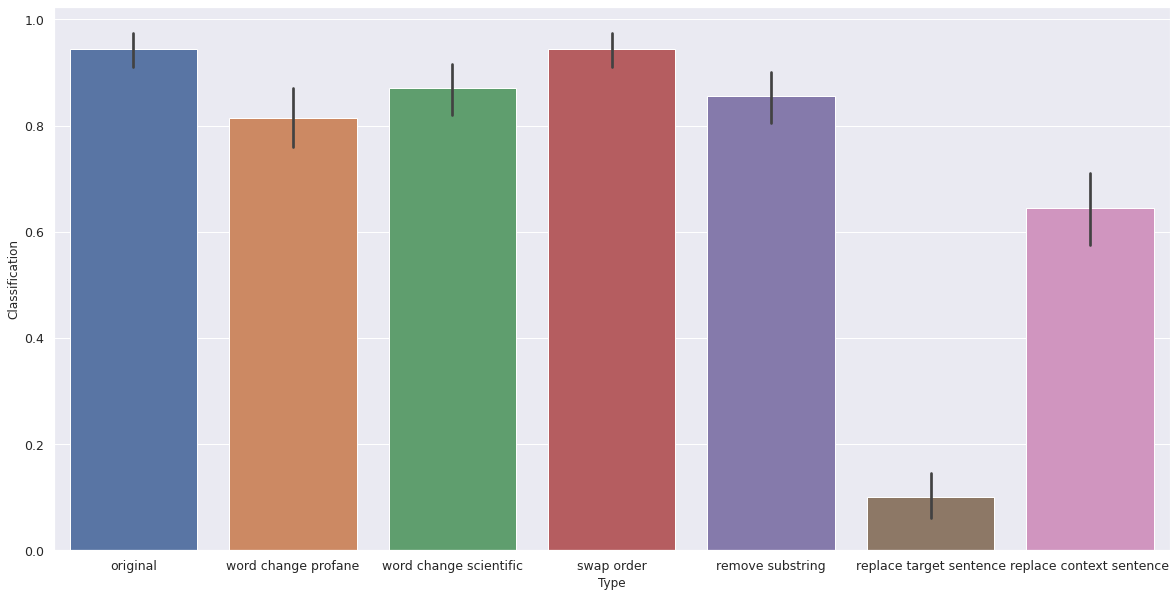

In [ ]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(20,10)})
ax = sns.barplot(x="Type", y="Classification", data=df)
ax.tick_params(labelsize=12.5)

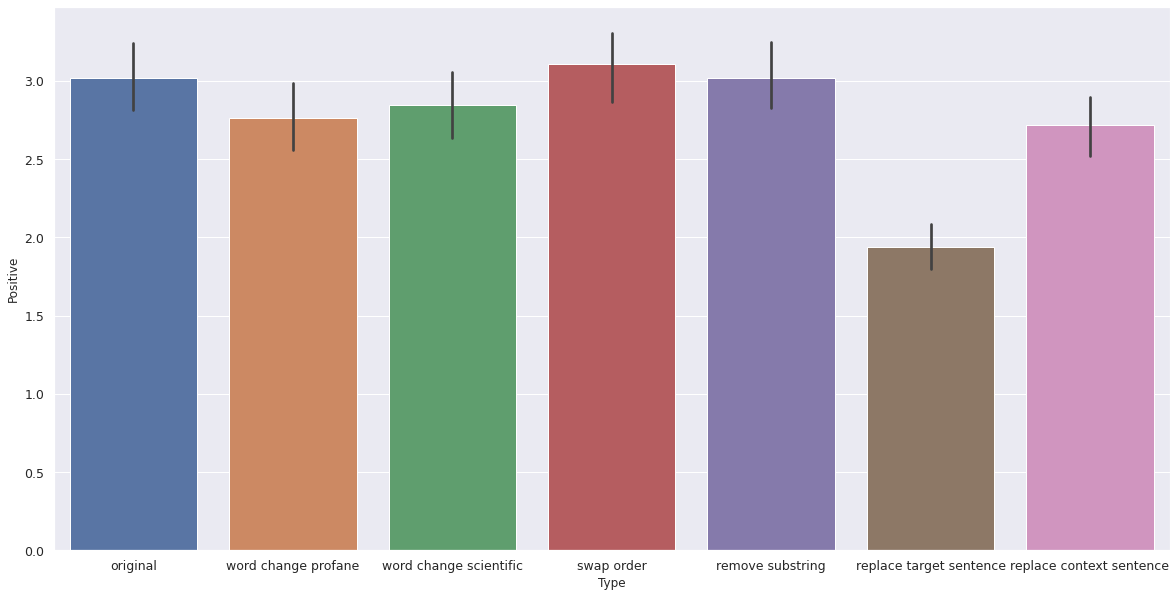

In [ ]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(20,10)})
ax = sns.barplot(x="Type", y="Positive", data=df)
ax.tick_params(labelsize=12.5)

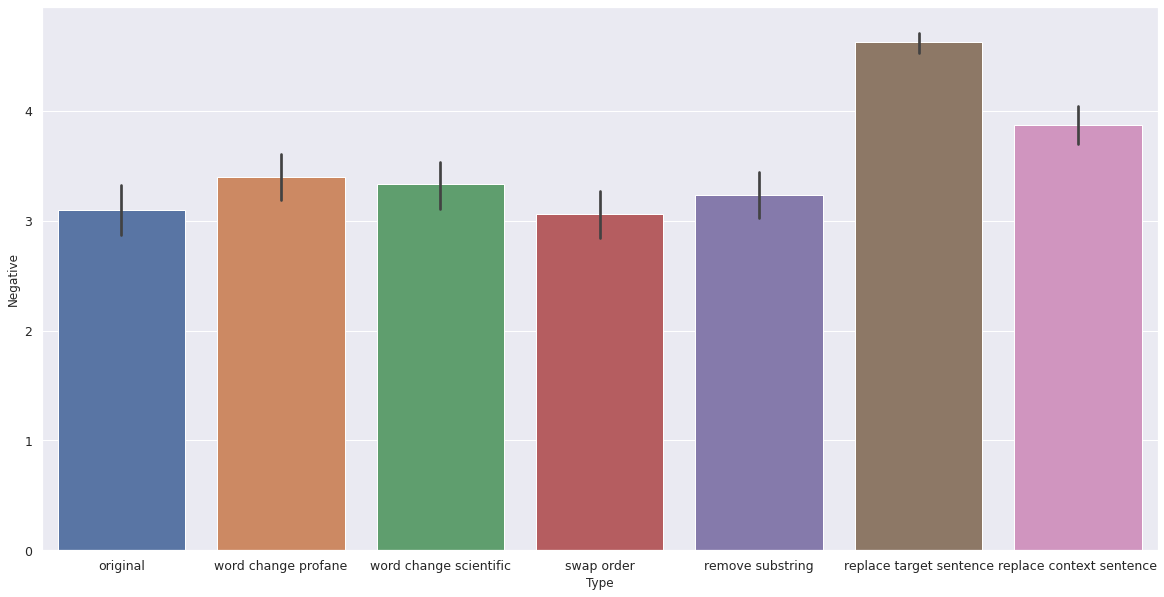

In [ ]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(20,10)})
ax = sns.barplot(x="Type", y="Negative", data=df)
ax.tick_params(labelsize=12.5)